In [85]:
import pandas as pd
import numpy as np
import librosa
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import torchaudio
import torch.nn.functional as F

import random
import glob
import os
import csv
import io
import ast

import sys
sys.path.append("..")
import utils

In [86]:
RANDOM_SEED = 21

# Set seed for experiment reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [87]:
is_in_kaggle_env = utils.get_is_in_kaggle_env()

We are running code on Localhost


In [88]:
data_path = '/kaggle/input/birdclef-2023' if is_in_kaggle_env else '../data'

In [89]:
device = 'cpu' if is_in_kaggle_env else utils.determine_device()

We are using device: mps


In [90]:
if not is_in_kaggle_env and not os.path.exists('../data'):
    !kaggle competitions download -c 'birdclef-2023'
    !mkdir ../data
    !unzip -q birdclef-2023.zip -d ../data
    !rm birdclef-2023.zip

## Data Exploration

In [91]:
audio_numpy, audio_sr = librosa.load(f"{data_path}/train_audio/abethr1/XC128013.ogg", sr=32000)

In [92]:
type(audio_numpy), type(audio_sr), audio_sr, audio_numpy.shape

(numpy.ndarray, int, 32000, (1459513,))

In [93]:
Audio(data=audio_numpy, rate=audio_sr)

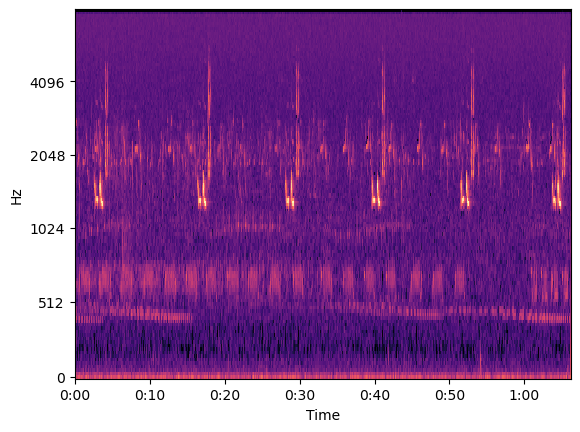

In [94]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio_numpy, sr=audio_sr, n_mels=128)

librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')

In [95]:
def normalize_spectrogram(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)
    if max_val - min_val == 0:
        return spectrogram
    else:
        return (spectrogram - min_val) / (max_val - min_val)

Duration of the audio: 45.60978125 seconds
norm_log_mel_spectrogram shape: (128, 2851)


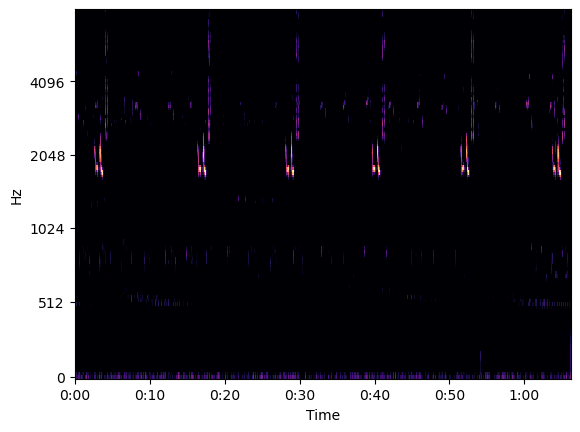

In [96]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio_numpy, sr=audio_sr, n_mels=128, fmax=8000)
log_mel_spectrogram = librosa.amplitude_to_db(mel_spectrogram)
norm_log_mel_spectrogram = normalize_spectrogram(log_mel_spectrogram)

print(f"Duration of the audio: {len(audio_numpy) / audio_sr} seconds")

print(f"norm_log_mel_spectrogram shape: {norm_log_mel_spectrogram.shape}")

librosa.display.specshow(norm_log_mel_spectrogram, y_axis='mel', fmax=8000, x_axis='time')

In [97]:
print(f"Shape of the spectrogram: {norm_log_mel_spectrogram.shape}")

Shape of the spectrogram: (128, 2851)


In [98]:
SAMPLE_RATE = 32_000
AUDIO_LENGTH_S = 5

## REUSE IN INFERENCE NOTEBOOK

def resample(audio, current_sample_rate, desired_sample_rate=SAMPLE_RATE):
    resampler = torchaudio.transforms.Resample(orig_freq=current_sample_rate, new_freq=desired_sample_rate)
    resampled_audio = resampler(audio)
    return resampled_audio

def load_audio(audio_path, sample_rate=SAMPLE_RATE):
    audio, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        audio = resample(audio, sr, sample_rate)
    return audio

get_melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    win_length=1024,
    hop_length=320,
    n_mels=128,
    f_min=0,
    f_max=16000,
    power=2.0,
    normalized=True,
    # sample_rate=32_000,
    # n_mels=128,
    # n_fft=2048, 
    # hop_length=512,
    # f_min=0,
    # f_max=32_000 // 2,
)

melspec_to_db = torchaudio.transforms.AmplitudeToDB(
    stype='power',
    top_db=80
)

def normalize_melspec(spectrogram):
    min_val = torch.min(spectrogram)
    max_val = torch.max(spectrogram)
    if max_val - min_val == 0:
        return spectrogram
    else:
        return (spectrogram - min_val) / (max_val - min_val)

In [99]:
pad_method = 'wrap'
crops_per_class = 5

audio = load_audio(f"{data_path}/train_audio/abethr1/XC128013.ogg", SAMPLE_RATE)

# Increase audio length if below {AUDIO_LENGTH_S} by padding
if audio.shape[1] < AUDIO_LENGTH_S * SAMPLE_RATE:
    padding_needed = AUDIO_LENGTH_S * SAMPLE_RATE - audio.shape[1]

    if pad_method in ['wrap', 'wrap_mirror']:
        audio = F.pad(audio, (0, padding_needed), mode='replicate')

    elif pad_method == 'zeros':
        audio = F.pad(audio, (0, padding_needed), mode='constant', value=0)

# Create a mirrored version of the audio array and concatenate it
if pad_method == 'wrap_mirror':
    mirrored_audio_torch = audio.flip(dims=(1,))
    audio = torch.cat((audio, mirrored_audio_torch), dim=1)

# Taking random crops of length AUDIO_LENGTH_S * SAMPLE_RATE
crops = []
if audio.shape[1] > AUDIO_LENGTH_S * SAMPLE_RATE:
    # The audio is longer than the desired length, so we take random crops
    for _ in range(crops_per_class):
        max_start_idx = audio.shape[1] - (SAMPLE_RATE * AUDIO_LENGTH_S)
        start_idx = torch.randint(0, max_start_idx, (1,)).item()
        crop = audio[:, start_idx:start_idx + (SAMPLE_RATE * AUDIO_LENGTH_S)]
        normalized_db_melspec = normalize_melspec(melspec_to_db(get_melspec(crop)))
        crops.append(normalized_db_melspec)
elif audio.shape[1] == AUDIO_LENGTH_S * SAMPLE_RATE:
    # The audio is exactly the desired length, so we don't need to crop, and add it crops_per_class times
    normalized_db_melspec = normalize_melspec(melspec_to_db(get_melspec(audio)))
    for _ in range(crops_per_class):
        crops.append(normalized_db_melspec)
else:
    # The audio is shorter than the desired length, which means the padding above didn't work
    raise Exception(f"Audio is shorter than {AUDIO_LENGTH_S} seconds: {audio.shape[1] / SAMPLE_RATE} seconds")

for crop in crops:
    print(crop.shape)

torch.Size([1, 128, 501])
torch.Size([1, 128, 501])
torch.Size([1, 128, 501])
torch.Size([1, 128, 501])
torch.Size([1, 128, 501])
